# Final Project!!!!
<br>

In [67]:
from time import time

import pandas as pd
import numpy as np
# make sure we display all the columns
pd.set_option('display.max_columns', 25)
from matplotlib import pyplot as plt
%matplotlib inline

## The Articles DataFrame

In [28]:
articles = pd.read_pickle('data/df.pkl')

print "Shape of Articles DataFrame: ", articles.shape
print
print "-- Sample Article --"
print
print articles.iloc[13]
print
print "Title: %s" % articles.iloc[13].resolved_title
print
print "Excerpt: %s" % articles.iloc[13].excerpt
print
print "Text: %s..." % articles.iloc[13].text[:500]

Shape of Articles DataFrame:  (612, 8)

-- Sample Article --

excerpt           Venmo, which lets Americans easily send money ...
resolved_id                                               874247130
resolved_title    The emoji of Venmo: food, booze, partying, and...
resolved_url               http://qz.com/359903/the-emoji-of-venmo/
text              Drowning in a sea of emoji. (Flickr user forre...
type                                                        article
is_archived                                                    True
word_count                                                      416
Name: 20, dtype: object

Title: The emoji of Venmo: food, booze, partying, and, occasionally, rent

Excerpt: Venmo, which lets Americans easily send money to each other from their phones, is rapidly replacing cash. The app processed $700 million in the third quarter of 2014, up from $141 million in the same quarter of 2013.

Text: Drowning in a sea of emoji. (Flickr user forresto)
Venmo, whi

### Column Definitions
* **resolved_id** - A unique identifier that is unique to the actual url of the saved item. The resolved_id identifies unique urls.
* **word_count** - How many words are in the article
* **resolved_title** - The title that Pocket found for the item when it was parsed
* **resolved_url** - The final url of the item. For example if the item was a shortened bit.ly link, this will be the actual article the url linked to.
* **text** - The text that was scraped + cleaned (returned by diffbot)
* **is_archived** - True/False (Have I read the article and archived it?)
* **excerpt** - The first few lines of the item (articles only)
* **type** - 'article', carryover from diffbot

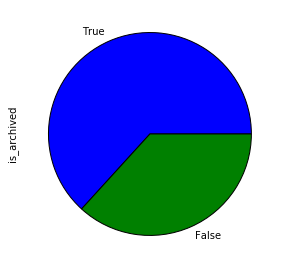

In [58]:
_ = articles[['is_archived']]\
    .apply(pd.Series.value_counts).plot.pie(subplots=True, figsize=(10,10), legend=False, layout=(2,2))    

8 articles have greater than 10k word counts
604 articles have less than 10k word counts


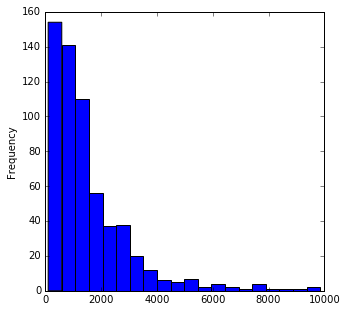

In [59]:
print "%s articles have greater than 10k word counts" % len(articles[articles.word_count > 10000])
print "%s articles have less than 10k word counts" % len(articles[articles.word_count < 10000])
_ = articles[articles.word_count < 10000].word_count.plot.hist(bins=20, figsize=(5,5))

## Text Featurization
http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#example-text-document-clustering-py

It can be noted that k-means is very sensitive to feature scaling and that in this case the IDF weighting helps improve the quality of the clustering

In [70]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorizeInputs(n, min_df, max_df, data):
    print "Extracting features from the training dataset using a tf-idf vectorizer"
    t0 = time()
    more_stop_words = set()
    with open('SuperSmartStopList.txt', 'rb') as fp:
        for line in fp:
            more_stop_words.add(line.strip())
    vectorizer = TfidfVectorizer(
        stop_words=text.ENGLISH_STOP_WORDS.union(more_stop_words),
        max_features=n, 
        max_df=max_df, 
        min_df=min_df, 
        sublinear_tf=True,
        decode_error='ignore', 
        lowercase=True)
    x = vectorizer.fit_transform(data).todense()
    terms = vectorizer.get_feature_names()
    print "done in %fs" % (time() - t0)
    print "n_samples: %d, n_features: %d" % x.shape
    print
    return x, terms

### 20newsgroups (~18k) + articles (~600)

With k-means, its recommended to have at least 10k rows of data. Article data would definitely be preferable, but in its absence I decided to use the 20newsgroups dataset. At 18k+ rows, that is plenty to train k-means but, unfortunately, 20newsgroups classes will overpower any effect the article data could have on the model. 

**Pros**:
 - Accessible text data
 - Keeps the focus on model building, not ETL. 
 
**Cons**: 
 - Should forcibly "snap" ground truth article classes to 20 newsgroups classes

In [106]:
from sklearn.datasets import fetch_20newsgroups

def fetchInputs():
    print "Loading 20 newsgroups dataset"
    dataset = fetch_20newsgroups(subset='all', categories=None, shuffle=True, random_state=42)
    labels = dataset.target
    true_k = np.unique(labels).shape[0]
    
    print "%d documents" % len(dataset.data)
    print "%d categories" % len(dataset.target_names)
    print
    return dataset.data, labels, true_k

# Maximum number of features (dimensions) to extract from text
n_features = 10000
# Minimum document frequency
min_df = 0.005
# Maximum document frequency
max_df = 0.95

# fetch 20 newsgroups
data, labels, true_k = fetchInputs()

# combine with article data
combined_data = data + list(articles['text'])

# tf-idf vectorizing w/o article data (metrics uses this)
_X, feature_names = vectorizeInputs(n_features, min_df, max_df, data)

# tf-idf vectorizing w/ article data
X_article, article_feature_names = vectorizeInputs(n_features, min_df, max_df, combined_data)

Loading 20 newsgroups dataset
18846 documents
20 categories

Extracting features from the training dataset using a tf-idf vectorizer
done in 5.463946s
n_samples: 18846, n_features: 3320

Extracting features from the training dataset using a tf-idf vectorizer
done in 6.062740s
n_samples: 19458, n_features: 3656



### LSA (Latent Semantic Analysis)
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

**Pros**: 
 - Speeds up training process significantly
 - Find relations between terms (synonymy and polysemy).
 
**Cons**:
 - Feature Loss / Information Loss
 - Introduces another variable that requires tweaking

In [107]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

def performLSA(n, x, normalize=True, verbose=True):
    if not n:
        if verbose:
            print "Not performing dimensionality reduction. n=%d" % n
            print
        return x, None
    
    if verbose:
        print "Performing dimensionality reduction using LSA n=%d" % n
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n)
    if normalize:
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
    else:
        lsa = svd
    x = lsa.fit_transform(x)
    if verbose:
        print "done in %fs" % (time() - t0)

    explained_variance = svd.explained_variance_ratio_.sum()
    if verbose:
        print "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
        print  
    return x, svd

# Preprocess documents with latent semantic analysis.
n_components = 100

# latent sematic analysis is used tob reduce dimensionality 
# and discover latent patterns in the data.
r_X, r_svd = performLSA(n_components, _X)

# with article data
r_X_article, r_svd_article = performLSA(n_components, X_article)

Performing dimensionality reduction using LSA n=100
done in 2.369709s
Explained variance of the SVD step: 18%

Performing dimensionality reduction using LSA n=100
done in 2.834749s
Explained variance of the SVD step: 18%



## Clustering with k-means

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#example-text-document-clustering-py

The Silhouette Coefficient, which is classically used as a k-means measure, is useless in combination with TF-IDF text features. The measure seems to suffer from the phenomenon called “Concentration of Measure” or “Curse of Dimensionality” for high dimensional datasets such as text data. Instead, the following measures are used, 

 - **Homogeneity** - [0.0, 1.0]
 - **Completeness** - [0.0, 1.0]
 - **V-measure** - [0.0, 1.0]

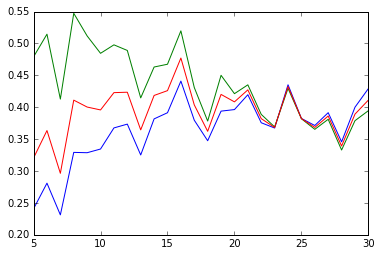

In [108]:
from sklearn import metrics
from sklearn.cluster import KMeans

def performClustering(num_clusters, data, verbose=True):
    # Note: as k-means is optimizing a non-convex objective function, it will likely end up 
    # in a local optimum. Several runs with independent random init might be necessary to 
    # get a good convergence.
    km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, verbose=verbose)
    if verbose:
        print "Clustering sparse data with %s" % km
        print
        t0 = time()
    km.fit(data)
    if verbose:
        print "done in %0.3fs" % (time() - t0)
        print
    return km

# try out various sizes of k, even though the ground truth has 20 classes
homogeneity = []
completeness = []
v_measure = []
max_k = 30

for k in xrange(5, max_k+1):
    # do clustering
    primary_cluster_model = performClustering(k, r_X, verbose=False)
    homogeneity.append(metrics.homogeneity_score(labels, primary_cluster_model.labels_))
    completeness.append(metrics.completeness_score(labels, primary_cluster_model.labels_))
    v_measure.append(metrics.v_measure_score(labels, primary_cluster_model.labels_))
    
plt.plot(xrange(5, max_k+1), homogeneity)
plt.plot(xrange(5, max_k+1), completeness)
plt.plot(xrange(5, max_k+1), v_measure)
plt.show()

### Apply k-means to combined 20newsgroup + article data

In [164]:
primary_cluster_model = performClustering(true_k, r_X_article, verbose=False)
print "Top terms per cluster:"
if n_components:
    original_space_centroids = r_svd_article.inverse_transform(primary_cluster_model.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = primary_cluster_model.cluster_centers_.argsort()[:, ::-1]

cluster_terms = {}
for i in range(true_k):
    cluster_terms[i] = ''
    
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        s = ' %s' % article_feature_names[ind]
        cluster_terms[i] += s
        print s,
    print
print

Top terms per cluster:
Cluster 0:  stanford  news  software  vms  vax  leland  usa  university  vnews  article
Cluster 1:  god  jesus  christian  bible  christians  christ  people  rutgers  church  don
Cluster 2:  clipper  key  chip  encryption  keys  escrow  government  algorithm  netcom  crypto
Cluster 3:  bike  dod  article  ride  writes  ca  riding  bikes  bmw  organization
Cluster 4:  game  team  games  hockey  ca  players  year  baseball  season  win
Cluster 5:  people  government  writes  article  israel  gun  state  don  law  fbi
Cluster 6:  drive  scsi  ide  drives  hard  controller  mac  bus  pc  organization
Cluster 7:  uk  ac  university  organization  writes  article  posting  host  nntp  demon
Cluster 8:  car  cars  engine  article  writes  good  ford  organization  price  speed
Cluster 9:  nasa  gov  space  writes  article  henry  jpl  shuttle  organization  orbit
Cluster 10:  windows  dos  files  program  run  organization  version  microsoft  os  running
Cluster 11:  c

### Plotting clusters with SVD

latent sematic analysis can also be used to produce scatter plots of clusterings. 

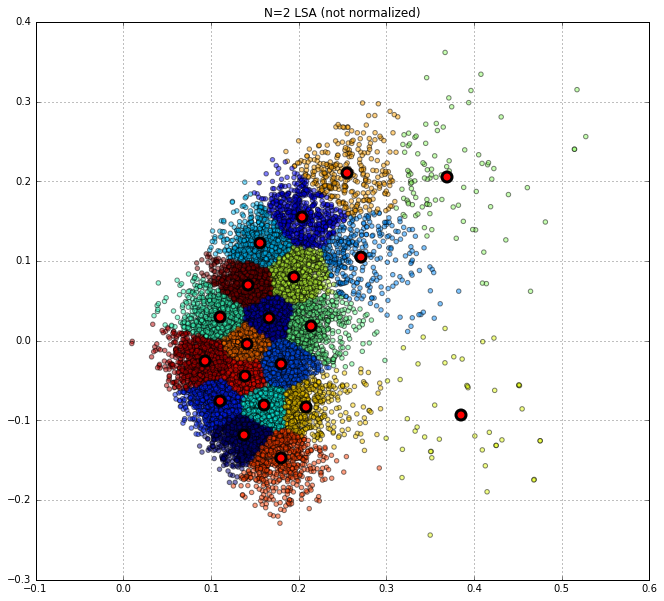

In [165]:
# graphical clustering (not normalized)
g_X, g_svd = performLSA(2, X_article, normalize=False, verbose=False)
g_km = performClustering(true_k, g_X, verbose=False)
g_centers2D = g_km.cluster_centers_

fig = plt.figure(figsize=(11,22), tight_layout=False)

ax1 = plt.subplot(211)
ax1.scatter(g_X[:,0], g_X[:,1], c=g_km.labels_, alpha=0.5)
ax1.scatter(g_centers2D[:,0], g_centers2D[:,1], marker='o', s=100, linewidth=3, c='r')
ax1.grid(True)
ax1.set_xlabel('', fontsize=20)
ax1.set_ylabel('', fontsize=20)
ax1.set_title('N=2 LSA (not normalized)')
plt.show()

### Revisiting Articles

In [169]:
# make predictions
predicts = list(primary_cluster_model.predict(r_X_article))
article_predicts = pd.Series(predicts[len(data):])

for cid, total in article_predicts.value_counts().iteritems():
    print cluster_terms[cid]
    print total
    print 

 code work make people things ve don good ll long
587

 nasa gov space writes article henry jpl shuttle organization orbit
9

 people government writes article israel gun state don law fbi
7

 organization mail ca university article reply writes 10 distribution don
4

 windows dos files program run organization version microsoft os running
2

 car cars engine article writes good ford organization price speed
1

 game team games hockey ca players year baseball season win
1

 god jesus christian bible christians christ people rutgers church don
1



## The Links DataFrame

In [97]:
df_links = pd.read_pickle('data/df_links.pkl')
print "Shape of Links DataFrame: ", df_links.shape
df_links.head()

Shape of Links DataFrame:  (7231, 2)


,link,resolved_id
0,https://en.wikipedia.org/wiki/W3C,169103241
1,https://en.wikipedia.org/wiki/Umbrella_term,169103241
2,https://en.wikipedia.org/wiki/CEO,169103241
3,https://en.wikipedia.org/wiki/Ecma_International,169103241
4,https://en.wikipedia.org/wiki/Internet_Enginee...,169103241


## Appendix A: Extracting text using pocket_diffbot.py

pocket_diffbot.py is responsible for collecting the data used in this notebook by performing the following tasks:
 - Authorizing getpocket.com API access
 - Requesting the JSON from getpocket.com containing all article data
 - Requesting diffbot's "Analyze" API to return data on each getpocket.com article. 
 - Stripping all href tags from each getpocket.com article body
 - Storing the results of all of the above to a mongo database
 
The data that eventually gets stored to mongo looks something like, 

```
 {
        "authors": {
            "36841772": {
                "author_id": "36841772",
                "item_id": "995154957",
                "name": "Michael Hoffman",
                "url": "https://medium.com/@hoffm"
            }
        },
        "diffbot_response": {
            "author": "Michael Hoffman",
            "date": "Tue, 28 Jul 2015 00:00:00 GMT",
            "html": "[... full html truncated for brevity...]",
            "human_language": "en",
            "icon": "https://cdn-static-1.medium.com/_/fp/img/apple-touch-icon.JWwtHOsKxVkBzoR3FSccjw.png",
            "images": [
                {
                    "caption": "Google\u2019s 2004 number theory scavenger hunt",
                    "primary": "true",
                    "url": "https://cdn-images-1.medium.com/max/800/1*Zt4ihF8mZPjiYXsnrxCnSA.jpeg"
                }
            ],
            "tags": [
                "Customer service"
            ],
            "text": "...full text truncated for brevity...]",
            "title": "A Good Engineer is a Lazy Engineer",
            "type": "article",
            "url": "https://medium.com/@hoffm/shhh-this-seal-is-writing-good-code-98fece3835d8"
        },
        "excerpt": "The customer care manager at my company was hiring for a position that involved responding to customer emails. As part of the application process, she asked candidates to respond to a sample customer complaint.  One applicant submitted a response that sounded oddly familiar.",
        "extracted_links": [
            "https://github.com/alpaker",
            "http://googleblog.blogspot.com/2004/07/warning-we-brake-for-number-theory.html",
            "https://twitter.com/zemskysobor"
        ],
        "favorite": "0",
        "given_title": "",
        "given_url": "https://medium.com/@hoffm/shhh-this-seal-is-writing-good-code-98fece3835d8",
        "has_image": "1",
        "has_video": "0",
        "image": {
            "height": "0",
            "item_id": "995154957",
            "src": "https://cdn-images-1.medium.com/max/800/1*Zt4ihF8mZPjiYXsnrxCnSA.jpeg",
            "width": "0"
        },
        "images": {
            "1": {
                "caption": "Google\u2019s 2004 number theory scavenger hunt",
                "credit": "",
                "height": "0",
                "image_id": "1",
                "item_id": "995154957",
                "src": "https://cdn-images-1.medium.com/max/800/1*Zt4ihF8mZPjiYXsnrxCnSA.jpeg",
                "width": "0"
            }
        },
        "is_article": "1",
        "is_index": "0",
        "item_id": "995154957",
        "resolved_id": "995154957",
        "resolved_title": "A Good Engineer is a Lazy Engineer \u2014 Medium",
        "resolved_url": "https://medium.com/@hoffm/shhh-this-seal-is-writing-good-code-98fece3835d8",
        "sort_id": 594,
        "status": "0",
        "time_added": "1438791308",
        "time_favorited": "0",
        "time_read": "0",
        "time_updated": "1438791309",
        "word_count": "401"
    },
```


## Appendix B: Transforming JSON -> DataFrame

json_to_df.py is the second component of the ETL pipeline that takes over where pocket_diffbot.py left off. The point of separation centers around storing to Mongo, which is a crucial part considering the amount of scraping and api requests that need to take place. json_to_df.py performs the following tasks:
 - Reads results from Mongo
 - Trims the results down to just the fields needed for analysis
 - Separates the main data from new links data (which are, so far, unscraped)
 - Converts JSONs to DataFrames
 - Imposes some restrictions on the data:
     - 'text' must not be null
     - 'word_count' must be greater than 100 (tf-idf requirement)
 - Finally, stores the results locally using pickle
 
The DataFrames that result from these transformations look something like...

```
Shape of Pocket DataFrame:  (612, 9)
Shape of Links DataFrame:  (7231, 2)

-- Sample Article --

excerpt           In an engineering organization with many small...
resolved_id                                              1254839939
resolved_title    Becoming a Tech Lead: How I've Balanced Coding...
resolved_url      http://product.hubspot.com/blog/tech-lead-bala...
status                                                            0
text              Tweet\nIn an engineering organization with man...
type                                                        article
is_archived                                                   False
word_count                                                     1706
Name: 9, dtype: object

-- Head of Links --
                                                link resolved_id
0                  https://en.wikipedia.org/wiki/W3C   169103241
1        https://en.wikipedia.org/wiki/Umbrella_term   169103241
2                  https://en.wikipedia.org/wiki/CEO   169103241
3   https://en.wikipedia.org/wiki/Ecma_International   169103241
4  https://en.wikipedia.org/wiki/Internet_Enginee...   169103241
```
